# Hacker News Stories

In this notebook...I used the latter option running the following query, that processed 9.7 GB when run 2019-05-05.

    SELECT * FROM `bigquery-public-data.hacker_news.full`
    WHERE score >= 50 AND type = "story" AND url != ""
    ORDER BY time DESC
    
In the code cell below, the Python libraries used in this notebook are imported, some variables set and the dataset loaded into a pandas DataFrame.

In [103]:
%matplotlib inline
%load_ext signature
import os
import re

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tld


mpl.style.use('ramiro')

attribution = 'Author: Ramiro Gómez - ramiro.org • Data: Hacker News - news.ycombinator.com'

data_file = os.path.expanduser('~/data/hackernews/hackernews_popular_stories_2019-05-05.csv')
df = pd.read_csv(data_file, parse_dates=['timestamp'])
df.head()

The signature extension is already loaded. To reload it, use:
  %reload_ext signature


,by,score,time,timestamp,title,type,url,text,parent,deleted,dead,descendants,id,ranking
0,workrockin,73,1557035426,2019-05-05 05:50:26+00:00,Network Offloading in Openwrt [pdf],story,https://openwrtsummit.files.wordpress.com/2018...,NaN,NaN,NaN,NaN,1.0,19831385,NaN
1,clouddrover,75,1557019551,2019-05-05 01:25:51+00:00,US Ride-Share Drivers Ready for Countrywide St...,story,https://www.thedrive.com/news/27824/us-ride-sh...,NaN,NaN,NaN,NaN,59.0,19830505,NaN
2,p1esk,166,1557012444,2019-05-04 23:27:24+00:00,OpenAI releases larger GPT-2 model,story,https://openai.com/blog/better-language-models...,NaN,NaN,NaN,NaN,33.0,19830042,NaN
3,ColinWright,77,1557009447,2019-05-04 22:37:27+00:00,Goro Shimura has died,story,https://en.wikipedia.org/wiki/Goro_Shimura,NaN,NaN,NaN,NaN,10.0,19829828,NaN
4,ingve,50,1557008719,2019-05-04 22:25:19+00:00,Learning new skills in InfoSec without getting...,story,https://azeria-labs.com/paradox-of-choice/,NaN,NaN,NaN,NaN,3.0,19829775,NaN


## Clean data and add columns

In [145]:
# Fixes for 
# http:////www.economist.com/science-and-technology/2018/09/06/how-a-shampoo-bottle-is-saving-young-lives
# http://jdebp.eu./FGA/operating-system-books.html
def fix_url(url):
    return url.replace('jdebp.eu.', 'jdebp.eu').replace('http:////', 'http://')

df['url'] = df.url.apply(lambda s: fix_url(s))

# Add column with full domain name, e.g. github.com
df['domain'] = df.url.apply(lambda s: tld.get_fld(s, fail_silently=True))

# https://stackoverflow.com/questions/42285130/how-floor-a-date-to-the-first-date-of-that-month
df['published'] = df.timestamp.dt.to_period('M').dt.to_timestamp()
df = df.loc[df.published < '2019-05']

info = 'Based on {:,d} Hacker News stories with a minimum score of 50 from October 2006 until April 2019.\n{}'.format(len(df), attribution)
df.shape

(161356, 16)

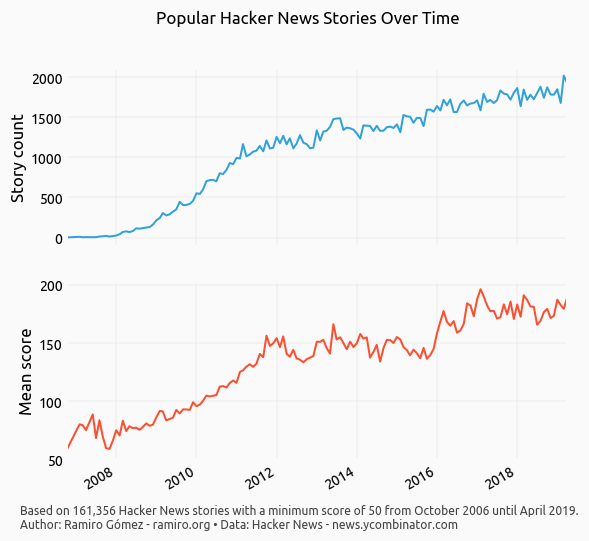

In [146]:
title='Popular Hacker News Stories Over Time'
by_published = df.groupby(df.published)['score'].agg(['count', 'mean'])
axes = by_published.plot(figsize=(8, 8), title=title, subplots=True, legend=None)
axes[0].get_yaxis().set_label_text('Story count')
axes[1].get_yaxis().set_label_text('Mean score')
axes[1].get_xaxis().set_label_text('')
plt.gcf().text(0, 0.1, info, ha='left', va='center', fontsize=12, color='#444444');

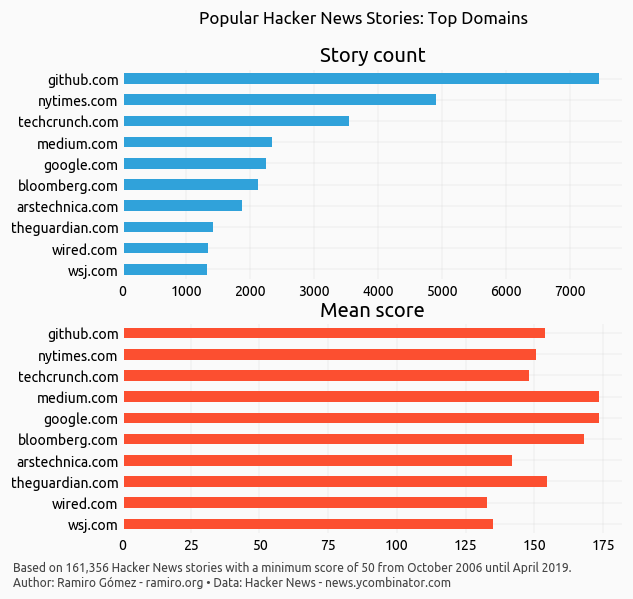

In [152]:
title='Popular Hacker News Stories: Top Domains'
by_domain = df.groupby(df.domain)['score'].agg(['count', 'mean'])
top_domains = by_domain.sort_values('count', ascending=False).head(10)[::-1]
axes = top_domains.plot(kind='barh', figsize=(8, 8), sharex=False, title=title, subplots=True, legend=None)

ax0 = axes[0]
ax0.set_title('Story count')
ax0.get_yaxis().set_label_text('')

ax1 = axes[1]
ax1.set_title('Mean score')
ax1.get_yaxis().set_label_text('')

plt.gcf().text(-0.11, 0, info, ha='left', va='center', fontsize=12, color='#444444');

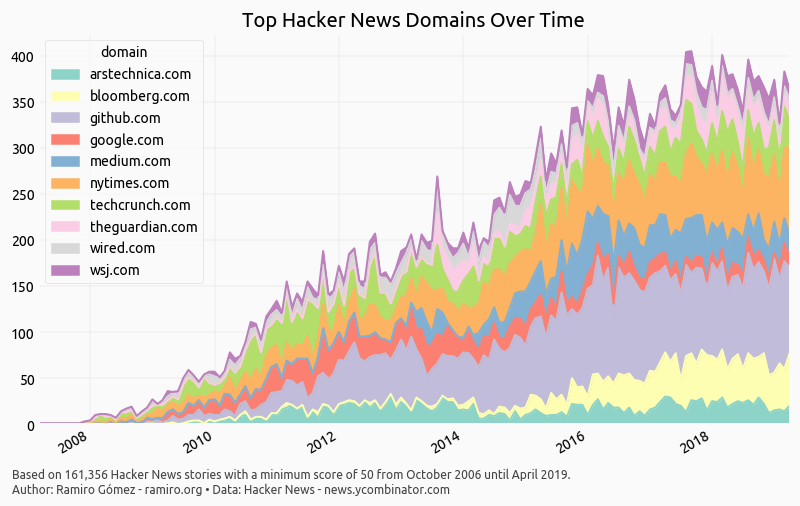

In [218]:
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd']
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', colors)

title = 'Top Hacker News Domains Over Time'

df_top_domains = df.loc[df.domain.isin(top_domains[:10].index)]
by_published_domain = df_top_domains.pivot_table(values='score', index='published', columns='domain', aggfunc='count')

ax = by_published_domain.plot(kind='area', figsize=(12, 8), stacked=True, colormap=cmap, title=title)
ax.set_xlabel('', visible=False)
plt.gcf().text(0.05, 0.1, info, ha='left', va='center', fontsize=12, color='#444444');

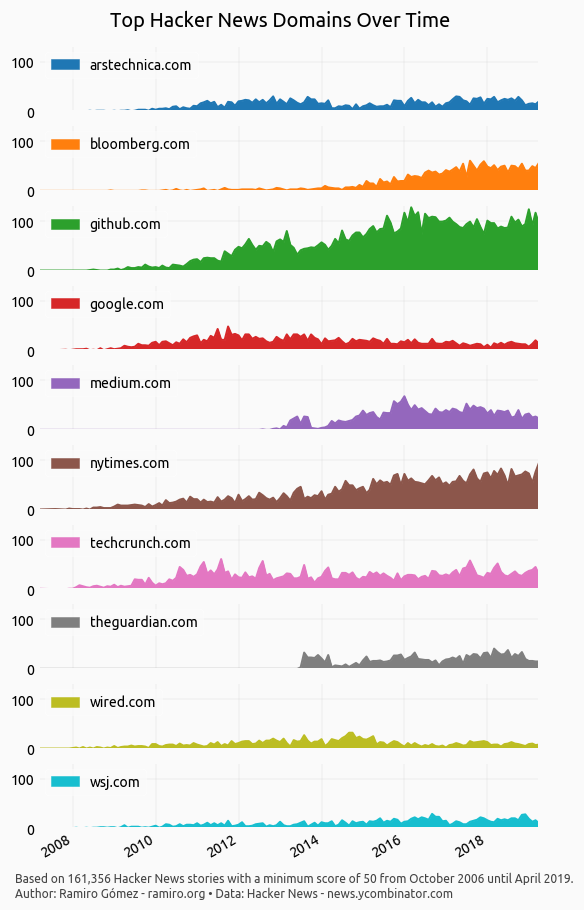

In [219]:
axes = by_published_domain.plot(kind='area', figsize=(8, 16), subplots=True, sharey=True, colormap='tab10')
for ax in axes:
    ax.legend(loc=2, edgecolor=(1, 1, 1, 0))
    ax.set_xlabel('', visible=False)

fig = plt.gcf()
fig.suptitle(title, y=0.91, fontsize=20)
fig.text(0.04, 0.15, info, ha='left', va='center', fontsize=12, color='#444444');

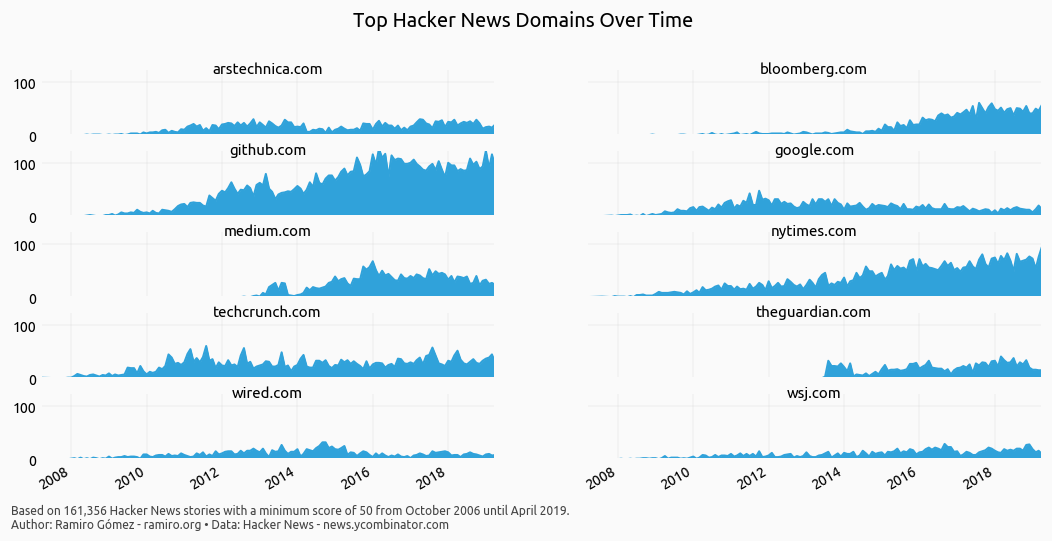

In [220]:
import itertools

nrows = 5
ncols = 2
y_max = by_published_domain.max().max()

fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(16, 8))
for idx, coords in enumerate(itertools.product(range(nrows), range(ncols))):
    ax = axes[coords[0], coords[1]]
    col = by_published_domain.columns[idx]
    by_published_domain[col].plot.area(ax=ax)
    ax.set_title(col, fontsize=15, verticalalignment='top')
    ax.set_xlabel('', visible=False)
    ax.set_ylim(top=y_max) # has to be set otherwise the chart is cut off

fig.suptitle(title, fontsize=20)
fig.text(0.055, 0.1, info, ha='left', va='center', fontsize=12, color='#444444');

In [225]:
df_domain_users = df_top_domains.pivot_table(values='score', index='by', columns='domain', aggfunc='count')
df_domain_users['techcrunch.com'].sort_values(ascending=False)[:5]

by
ssclafani     77.0
janober       57.0
prostoalex    48.0
doppp         36.0
coloneltcb    34.0
Name: techcrunch.com, dtype: float64

In [369]:
limit = 30
top_domains = df.domain.value_counts()[:limit].index
top_users = df.by.value_counts()[:limit].index
df_top = df.loc[df.domain.isin(top_domains) & df.by.isin(top_users)]
df_top_p = df_top.pivot_table(values='score', index='domain', columns='by', aggfunc='count')
# Case insensitive sort for index
df_top_p = df_top_p.reindex(sorted(df_top_p.columns, key=lambda x: x.lower()), axis=1)

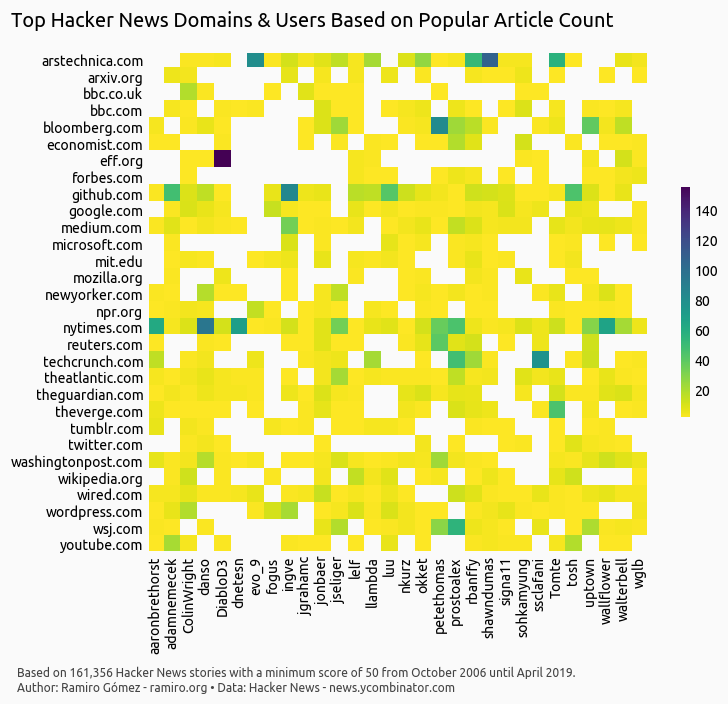

In [370]:
title = 'Top Hacker News Domains & Users Based on Popular Article Count'

mpl.rc('axes', grid=False)
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.Greens
img = ax.imshow(df_top_p, cmap=plt.cm.viridis_r)
ax.set_xticks(range(len(df_top_p.index)))
ax.set_yticks(range(len(df_top_p.columns)))
ax.set_xticklabels(df_top_p.columns)
ax.set_yticklabels(df_top_p.index)
plt.xticks(rotation=90)
fig.suptitle(title, fontsize=20, y=0.88, x=0.31)
fig.text(-0.1, -0.05, info, ha='left', va='center', fontsize=12, color='#444444')
plt.colorbar(img, shrink=0.4);

In [427]:
import networkx as nx

df_graph = df_top_p.stack().reset_index().rename(columns={0: 'weight'})
G = nx.from_pandas_edgelist(df_graph, source='by', target='domain', edge_attr=['weight'], create_using=nx.DiGraph)

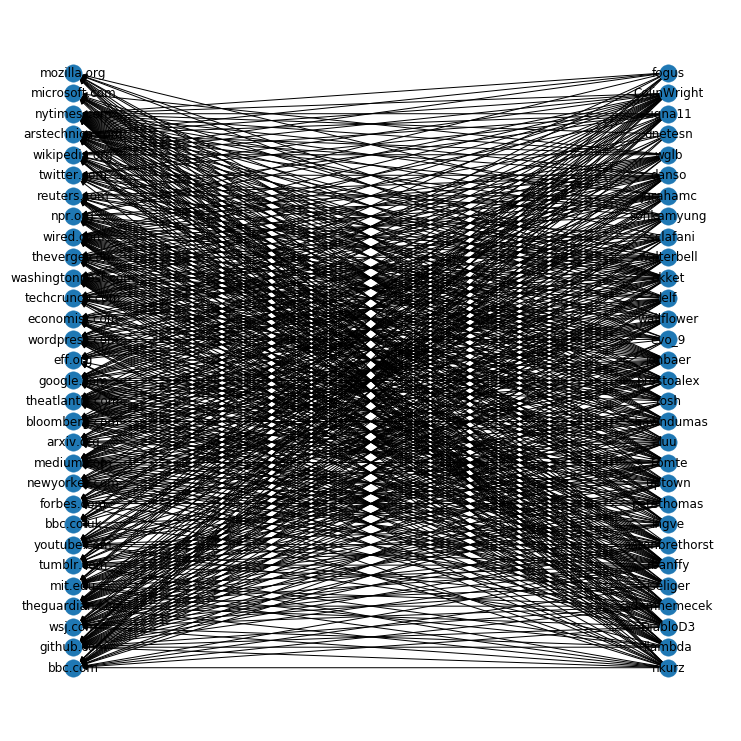

In [435]:
pos = nx.bipartite_layout(G, df_graph.domain)
nx.draw(G, pos=pos, with_labels=True)
plt.gcf().set_size_inches(10, 10)

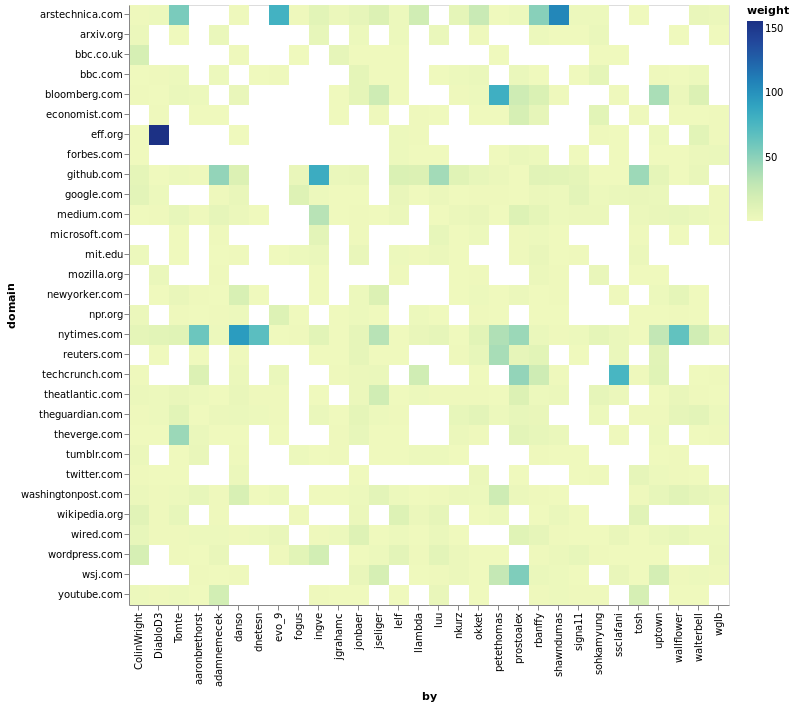

In [460]:
import altair as alt
alt.renderers.enable('jupyterlab')

alt.Chart(df_graph).mark_rect().encode(
    x='by:O',
    y='domain:O',
    color='weight:Q'
)